### Initialize and collect ohlcv data

In [2]:
import sys
sys.path.append('/Users/araschang/Desktop/coding/binance_trading_bot/')
import datetime
import time
import pandas as pd
import ccxt
from Module.indicators import *
import Module.constants as const
##### Bitget 與 Bybit 套利 #####
# input parameters

okx = ccxt.okx({
    'apiKey': const.okx_api_key,
    'secret': const.okx_api_secret,
    'password': const.okx_pass_phrase,
})
bitget = ccxt.bitget({
    'apiKey': const.bitget_api_key,
    'secret': const.bitget_api_secret,
    'password': const.bitget_pass_phrase,
})
binance = ccxt.binanceusdm({
    'apiKey': const.binance_future_api_key,
    'secret': const.binance_future_api_secret,
    'enableRateLimit': True,
    'option': {
        'defaultMarket': 'future',
    },
})

#### Load brokers' markets and check the differences

In [6]:
# okx
okx_list_tem = list(okx.load_markets().keys())
okx_list = []
for i in range(len(okx_list_tem)):
    if okx_list_tem[i][-5:] == ':USDT':
        okx_list.append(okx_list_tem[i][:-5])
bybit_list = set(okx_list)

#bitget
bitget_list_tem = list(bitget.load_markets().keys())
bitget_list = []
for i in range(len(bitget_list_tem)):
    if bitget_list_tem[i][-5:] == ':USDT':
        bitget_list.append(bitget_list_tem[i][:-5])
bitget_list = set(bitget_list)

#binance (a reference for fair values)
binance_list = set(binance.load_markets().keys())

#target markets
target_market = list(bitget_list & bybit_list)

##### 筆記：以幣安價格當作基準，如果一方高於幣安一方低於幣安則開125倍單，並考量到手續費，須以幣安價格為目標價，計算預計盈虧，扣除手續費如有利潤才可開單
okx 0.05%<br>
bitget 0.06%

In [44]:
df = pd.read_csv('/Users/araschang/Desktop/backtestdata_btc_1h.csv')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
# converting str to int
df['open'] = pd.to_numeric(df['open'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['close'] = pd.to_numeric(df['close'])
df['volume'] = pd.to_numeric(df['volume'])

### Indicators

In [55]:
import numpy as np
import pandas_ta as ta

def concat(df1, list1):
    list1 = pd.DataFrame(list1).T
    list1.columns = ['Start', 'End', 'Ratio']
    return pd.concat([df1, list1], axis=0, ignore_index=True)

a = 26
b = 83
c = 13
df['ATR'] = ATR(df, period=c)
df['5ema'] = EMA(df, a)
df['20ema'] = EMA(df, b)
high = pd.Series(df['high'])
low = pd.Series(df['low'])
close = pd.Series(df['close'])
df['super'] = pd.DataFrame(ta.supertrend(high, low, close))['SUPERTd_7_3.0']

df

,date,open,high,low,close,volume,ATR,5ema,20ema,super
0,2022-09-08 22:10:00,19149.6,19175.7,19117.9,19156.5,2488.218,NaN,NaN,NaN,1
1,2022-09-08 22:15:00,19156.6,19241.4,19130.1,19240.2,4160.624,NaN,NaN,NaN,1
2,2022-09-08 22:20:00,19240.2,19300.2,19203.5,19213.5,6708.135,NaN,NaN,NaN,1
3,2022-09-08 22:25:00,19213.4,19261.0,19200.0,19230.4,2600.957,NaN,NaN,NaN,1
4,2022-09-08 22:30:00,19230.3,19261.0,19209.5,19247.4,2179.891,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
995,2022-09-12 09:05:00,21617.0,21646.1,21595.4,21597.8,1882.891,58.665374,21688.053629,21656.438813,-1
996,2022-09-12 09:10:00,21597.8,21660.1,21597.8,21655.1,1273.044,59.184606,21685.612619,21656.406937,-1
997,2022-09-12 09:15:00,21655.0,21686.0,21650.0,21682.0,1551.445,55.872520,21685.345018,21657.016295,-1
998,2022-09-12 09:20:00,21682.0,21716.0,21658.0,21714.8,1700.127,56.176445,21687.526869,21658.392098,-1


### Backtesting

In [56]:
ret = []
signal = ''
transaction = pd.DataFrame([1,1,1]).T
transaction.columns = ['Start', 'End', 'Ratio']
trans = []
start_price = 0

for i in range(len(df)):

    if signal == '':
        ret.append(0)
        if df['close'][i]>df['5ema'][i]>df['20ema'][i] and df['super'][i-1] ==-1 and df['super'][i] == 1:
            signal = 'BUY'
            stop_loss = df['close'][i] - df['ATR'][i]
            # Don't touch
            trans.append(df['date'][i])
            start_price = df['close'][i]

        elif df['close'][i]<df['5ema'][i]<df['20ema'][i] and df['super'][i-1] == 1 and df['super'][i] == -1:
            signal = 'SELL'
            stop_loss = df['close'][i] + df['ATR'][i]
            # Don't touch
            trans.append(df['date'][i])
            start_price = df['close'][i]
    
    elif signal == 'BUY':
        if df['close'][i]<df['5ema'][i]:  # stop profit
            signal = ''

            # Don't touch
            ret.append((df['close'][i]/df['close'][i-1])-1)
            trans.append(df['date'][i])
            trans.append((df['close'][i] - start_price)/start_price)
            transaction = concat(transaction, trans)
            trans = []
            start_price = 0
        
        else:
            # Don't touch
            ret.append((df['close'][i]/df['close'][i-1])-1)
    
    elif signal == 'SELL':
        if df['close'][i]>df['5ema'][i]:  # normal stop profit
            signal = ''

            # Don't touch
            ret.append((df['close'][i-1]/df['close'][i])-1)
            trans.append(df['date'][i])
            trans.append((start_price - df['close'][i])/start_price)
            transaction = concat(transaction, trans)
            trans = []
            start_price = 0

        else:
            # Don't touch
            ret.append((df['close'][i-1]/df['close'][i])-1)

# Don't touch
transaction['Ratio'] = 100 * transaction['Ratio']
transaction = transaction.drop([0])
sum = transaction['Ratio'].sum()

# Total profit ratio and KPIs
ret = pd.DataFrame(ret, columns=['ret'])
winrate = transaction['Ratio'][transaction['Ratio']>0].count() / len(transaction)
print('Profit ratio(%):',sum)
print('Win rate(%):', winrate*100)
print('CAGR:',CAGR(ret))
print('Sharpe ratio:', sharpe(ret, 0.0343))
print('Max drawdown:', max_dd(ret))

Profit ratio(%): -0.14307423430206484
Win rate(%): 28.57142857142857
CAGR: -0.14520637427071204
Sharpe ratio: -2.0961998895941223
Max drawdown: 0.01792136039252626


### Plotting

<AxesSubplot:>

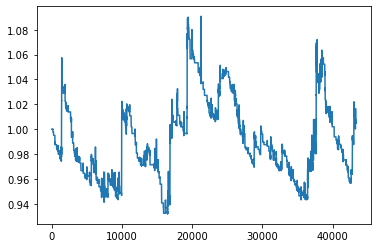

In [40]:
(1+ret["ret"]).cumprod().plot()

In [97]:
ret

,ret
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
995,0.003360
996,-0.000300
997,0.001668
998,0.002706
